https://www.kaggle.com/c/competitive-data-science-final-project

In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
%matplotlib inline 

import utility.utility as ut
from preprocessing.createSets import *
from preprocessing.Sets import Sets
from utility.ML import ML

In [2]:
########### switches ################################

saveName='Oct18-2018_1'
saveFolder = saveName
saveplots=False
createSubmit = False
if not os.path.exists(saveFolder) and (saveplots or createSubmit): 
    print 'creating folder:',os.getcwd()+'/'+saveFolder
    os.mkdir(saveFolder)
if(saveplots): print "SAVING PLOTS!"
if(createSubmit): print "WILL CREATE SUBMIT FILE!"

In [3]:
############# Options/Args #########################

verbose=False
lag_length = 4
diff = True
diffRel = True 
addPriceRange = True

target = 'shop_item_cnt_month'
# target = 'shop_item_cnt_month_diff(0-1)'

#these columns will be dropped in createTrain/Val/Test
col_targets=[
             'shop_item_cnt_month',
             # 'shop_cnt_month',
             # 'item_cnt_month',
             # 'item_cat_cnt_month',
            ]
if(diff):
    col_targets+=[
#                  'shop_item_cnt_month_diff(0-1)',
#                  'shop_cnt_month_diff(0-1)',
#                  'item_cnt_month_diff(0-1)',
#                  'item_cat_cnt_month_diff(0-1)',
                ]
if(diffRel):
    col_targets+=[
#                  'shop_item_cnt_month_(0-1)/1',
#                  'shop_cnt_month_(0-1)/1',
#                  'item_cnt_month_(0-1)/1',
#                  'item_cat_cnt_month_(0-1)/1',
                ]

####### mean Encode (with Reg) #####

meanEncode=True #this is just necessary condition for mean encoding. but need to turn on individual switches below to include columsn of target encoding.
meanEncodeCol=[ #this is for lag features.
             'shop',
             'item',
             'item_cat',
            ]

agg_targ = {'item_cnt_day':'sum'} #target_encoding!
# agg_targ = {'item_cnt_day':'mean'} #target_encoding!

Regularize = True
enc_cnt_per_shop = True
enc_cnt_per_item = True
enc_cnt_per_item_cat = True
enc_priceRange = True

targEnc_to_Reg = {}
NaN_targEnc = {}

if(enc_cnt_per_shop):targEnc_to_Reg.update({'shop_id':'shop'})
if(enc_cnt_per_item):targEnc_to_Reg.update({'item_id':'item'})
if(enc_cnt_per_item_cat):targEnc_to_Reg.update({'item_category_id':'item_cat'})
if(enc_priceRange):targEnc_to_Reg.update({'price_range':'price_range'})

if(enc_cnt_per_shop):NaN_targEnc.update({'shop':-999})
if(enc_cnt_per_item):NaN_targEnc.update({'item':-999})
if(enc_cnt_per_item_cat):NaN_targEnc.update({'item_cat':-999})
if(enc_priceRange):NaN_targEnc.update({'price_range':-999})

####################################

#columns to keep
col_to_keep = [
                'shop_id',
                'item_id',
                #'item_price',
                'item_category_id',
                'item_cnt_day',
                ]

groupby_list = ['shop_id','item_id']

agg_dict = {
            #'item_price':'mean',
            'item_category_id':'mean',
            'item_cnt_day':'sum',
            }

    
opt = {
        'verbose':verbose,
        'lag_length':lag_length,
        'diff':diff,
        'diffRel':diffRel,
        'target':target,
        'col_to_keep':col_to_keep,
        'groupby_list':groupby_list,
        'agg_dict':agg_dict,
        'agg_targ':agg_targ,
        'col_targets':col_targets,
        'meanEncode':meanEncode,
        'meanEncodeCol':meanEncodeCol,
        'targEnc_to_Reg':targEnc_to_Reg,
        'NaN_targEnc':NaN_targEnc,
        } 


#clipTarget = True
lowerClip = 0
upperClip = 20
if target=='shop_item_cnt_month_diff(0-1)':
    lowerClip = -20
    upperClip = 20    

########################################################

# create train/val/test set

In [4]:
Sets = Sets(**opt)

dup_ids = Sets.checkDuplicates()
Sets.convertDatetime()
Sets.addItemCategoryId()
Sets.addYMcolumn()
bin_edges=[0,10,100,200,500,1000,2500,5000,20000,999999]
Sets.binPrice(bin_edges)
Sets.splitDataByYear()
data = Sets.getData()

data['sales_train'].head()


lag_length: 4
diff: True
diffRel: True
target: shop_item_cnt_month

target encoding: {'item_cnt_day': 'sum'}



,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,year,month,Y_M,price_range
1972631,2014-09-01,20,54,0,58.0,1.0,40,2014,9,2014_9,"(10, 100]"
2069405,2014-10-20,21,55,1,4490.0,1.0,76,2014,10,2014_10,"(2500, 5000]"
1552547,2014-04-04,15,55,1,4490.0,1.0,76,2014,4,2014_4,"(2500, 5000]"
1815466,2014-07-06,18,55,1,4490.0,1.0,76,2014,7,2014_7,"(2500, 5000]"
1906676,2014-08-04,19,55,1,4490.0,1.0,76,2014,8,2014_8,"(2500, 5000]"


In [21]:
x_train, y_train = Sets.createTrainSet()
x_val, y_val = Sets.createValSet()
x_test = Sets.createTestSet()
print x_train.shape
print x_val.shape

(51460, 55)
(45755, 55)


# Adding price category to train,val, test

In [22]:
if(addPriceRange):x_train,x_val,x_test = Sets.addPriceRange(x_train,x_val,x_test)

train.shape: (2935843, 11)

Clipping train and val targets [0-20]



# Clip y_train, y_val

In [24]:
y_train,y_val = Sets.clipSalesCount(y_train,y_val,lowerClip,upperClip)


Clipping train and val targets [0-20]



In [25]:
#combine 2013+2014
# x_train  = pd.concat([x_train, x_val], ignore_index=True)
# y_train  = pd.concat([y_train, y_val], ignore_index=True)
# print x_train.shape

#combine part of 2014 to train
# x_train  = pd.concat([x_train, x_val[:27000]], ignore_index=True)
# y_train  = pd.concat([y_train, y_val[:27000]], ignore_index=True)
# x_val = x_val[27001:]
# y_val = y_val[27001:]

#x_val = x_train
x_val = x_train
y_val = y_train

In [28]:
print x_train.shape
print x_val.shape

(51460, 56)
(51460, 56)


# Target encode with KFold reg

In [29]:
x_train,x_val,x_test = Sets.mapTargetEnc(x_train,y_train,x_val,x_test,Regularize=Regularize)

Regularizing target encoding!
x_val: adding target encoding: item_cnt_month_kFold
x_val: adding target encoding: item_cat_cnt_month_kFold
x_val: adding target encoding: price_range_cnt_month_kFold
x_val: adding target encoding: shop_cnt_month_kFold
x_test: adding target encoding: item
x_test: adding target encoding: item_cat
x_test: adding target encoding: price_range
x_test: adding target encoding: shop


In [30]:
columns_to_drop = [
                'shop_item_id',
                  ]
x_train = x_train.drop(columns=columns_to_drop)
x_val = x_val.drop(columns=columns_to_drop)
x_test = x_test.drop(columns=columns_to_drop)
# make sure features are the same across sets
x_train = x_train.drop(columns=list(set(x_train.columns.values)-set(x_test.columns.values)))
x_val = x_val.drop(columns=list(set(x_val.columns.values)-set(x_test.columns.values)))

In [31]:
print 'x_train.shape:',x_train.shape
print 'x_val.shape:',x_val.shape
print 'x_test.shape:',x_test.shape 
print 'x_test columns:' 
for i,col in enumerate(x_test.columns.values): print ' '*3,i,col 
print
assert (set(x_train.columns.values)-set(x_test.columns.values)==set([])), "train/val has more features than test!"

x_train.shape: (51460, 48)
x_val.shape: (51460, 48)
x_test.shape: (214200, 48)
x_test columns:
    0 shop_id
    1 item_id
    2 item_category_id
    3 shop_item_cnt_month_lag_1
    4 shop_cnt_month_lag_1
    5 item_cnt_month_lag_1
    6 item_cat_cnt_month_lag_1
    7 shop_item_cnt_month_lag_2
    8 shop_cnt_month_lag_2
    9 item_cnt_month_lag_2
    10 item_cat_cnt_month_lag_2
    11 shop_item_cnt_month_diff(1-2)
    12 shop_item_cnt_month_(1-2)/2
    13 shop_cnt_month_diff(1-2)
    14 shop_cnt_month_(1-2)/2
    15 item_cnt_month_diff(1-2)
    16 item_cnt_month_(1-2)/2
    17 item_cat_cnt_month_diff(1-2)
    18 item_cat_cnt_month_(1-2)/2
    19 shop_item_cnt_month_lag_3
    20 shop_cnt_month_lag_3
    21 item_cnt_month_lag_3
    22 item_cat_cnt_month_lag_3
    23 shop_item_cnt_month_diff(2-3)
    24 shop_item_cnt_month_(2-3)/3
    25 shop_cnt_month_diff(2-3)
    26 shop_cnt_month_(2-3)/3
    27 item_cnt_month_diff(2-3)
    28 item_cnt_month_(2-3)/3
    29 item_cat_cnt_month_diff(2-3)


# Model Training

In [32]:
### Boosted Decision Tree (lightgbm)
import lightgbm as lgb

In [33]:
dataset = {
            'x_train':x_train,
            'x_val':x_val,
            'x_test':x_test,
            'y_train':y_train,
            'y_val':y_val,
            }

ml = ML(**dataset)

model,evals_result = ml.runBDT_lightgbm(
                    lgb_params = {
                                   'num_leaves': 2*4,
                                   'min_data_in_leaf': 2**7, 
                                   'max_depth': -1,
                                   'learning_rate': 0.03, 
                                   'objective': 'mse', 
                                   'metric': 'rmse',
                                   'nthread':4, 
                                   'feature_fraction': .75,
                                   'bagging_fraction': 0.75,#0.75 
                                   'bagging_freq':1,
                                   'bagging_seed': 2**7, 
                                   'verbose':1,
                                  }
                                        )

/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[1000]	train's rmse: 1.32196	eval's rmse: 1.29489
[2000]	train's rmse: 1.25901	eval's rmse: 1.2448
[3000]	train's rmse: 1.21581	eval's rmse: 1.21067
[4000]	train's rmse: 1.18217	eval's rmse: 1.18444
[5000]	train's rmse: 1.15328	eval's rmse: 1.16273
[6000]	train's rmse: 1.12888	eval's rmse: 1.14489
[7000]	train's rmse: 1.10667	eval's rmse: 1.12843
[8000]	train's rmse: 1.08706	eval's rmse: 1.11389
[9000]	train's rmse: 1.06889	eval's rmse: 1.1011
[10000]	train's rmse: 1.05233	eval's rmse: 1.09005
[11000]	train's rmse: 1.03673	eval's rmse: 1.07985
[12000]	train's rmse: 1.02181	eval's rmse: 1.06926
[13000]	train's rmse: 1.00829	eval's rmse: 1.05975
[14000]	train's rmse: 0.995717	eval's rmse: 1.05138
[15000]	train's rmse: 0.983249	eval's rmse: 1.0432
[16000]	train's rmse: 0.971617	eval's rmse: 1.03535
[17000]	train's rmse: 0.960681	eval's rmse: 1.02828
[18000]	train's rmse: 0.949697	eval's rmse: 1.02037
[19000]	train's rmse: 0.93

Plot metrics recorded during training...
Plot feature importances...


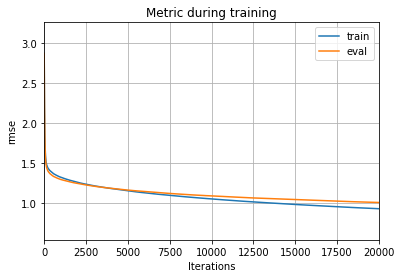

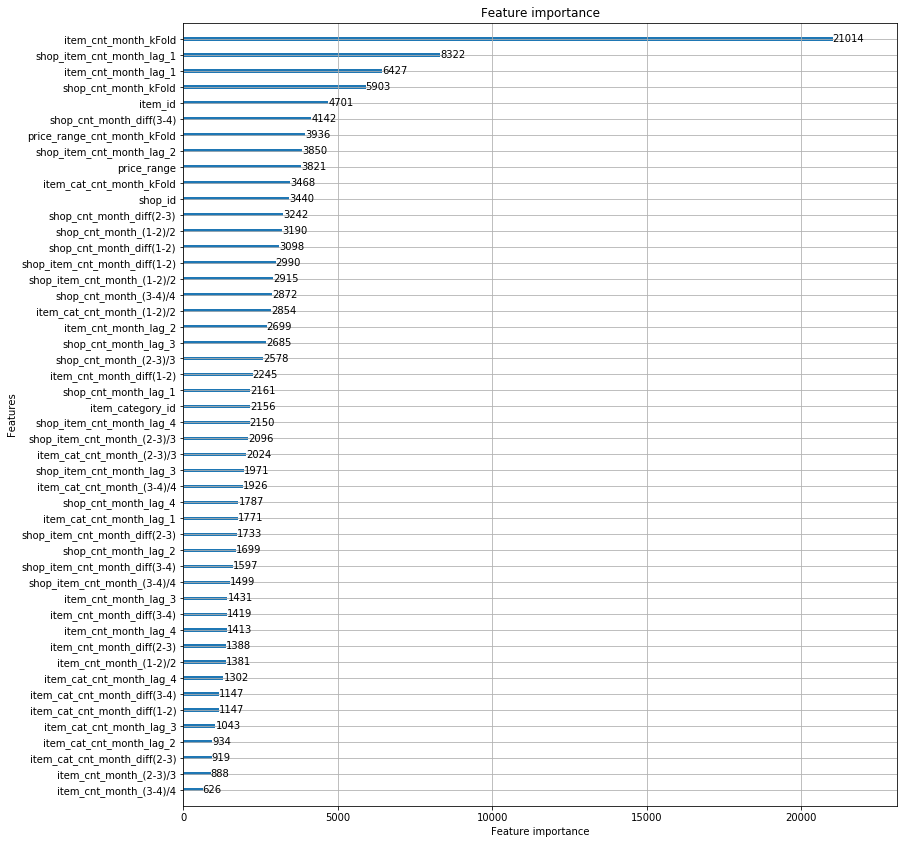

In [34]:
print('Plot metrics recorded during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
if(saveplots):plt.savefig(saveFolder+"/"+"lgb_plot_metric_"+saveName+".pdf")
#plt.show()

print('Plot feature importances...')
ax = lgb.plot_importance(model, max_num_features=x_test.shape[1])
ax.figure.set_size_inches(6.4*2,4.8*3)
if(saveplots):plt.savefig(saveFolder+"/"+"lgb_plot_importance_"+saveName+".pdf")
plt.show()

# Predict with test data¶

In [35]:
pred = ml.predict(model)

pred_submit = pred

In [36]:
print pred.size
print pred
print 'Sum pred:',np.sum(pred)
pred_submit = pred

214200
[1.45244656 1.54850487 1.41991106 ... 0.84925509 1.57897689 1.52085741]
Sum pred: 251177.8247913


In [37]:
#translate back to shop_item_cnt_month in needed
if target =='shop_item_cnt_month_diff(0-1)':  
    last_month_shop_item_cnt_month = sales_2015[sales_2015['month']==(10)].groupby(groupby_list,as_index=False).agg(agg_dict).rename(columns={'item_cnt_day':'shop_item_cnt_month_lag_1'})
    last_month_shop_item_cnt_month = last_month_shop_item_cnt_month[['shop_id','item_id','shop_item_cnt_month_lag_1']].head()
    df_temp = pd.merge(x_test[['shop_id','item_id']],last_month_shop_item_cnt_month,on=('shop_id','item_id'),how='left')
    df_temp.fillna(0,inplace=True)
    df_temp.head()

    df_pred = pd.DataFrame(pred,columns=['y_pred_residual'])
    df_pred.head()

    df_pred['y_pred'] = df_temp['shop_item_cnt_month_lag_1'] + df_pred['y_pred_residual']
    df_pred.head()

    pred_submit = df_pred['y_pred'].values
    
# True target values are clipped into [0,20] range.
pred_submit = np.clip(pred_submit,0,20)
    
print pred_submit


[1.45244656 1.54850487 1.41991106 ... 0.84925509 1.57897689 1.52085741]


total sales pred: 253676.29290011674 , mean: 1.184296418768052


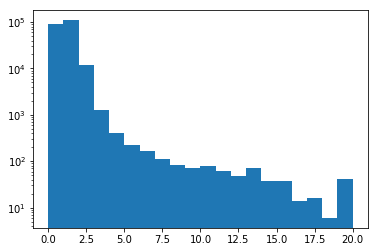

In [38]:
print 'total sales pred:',np.sum(pred_submit), ', mean:',np.mean(pred_submit)
hist_pred = plt.hist(pred_submit,bins=20,log=True)

In [39]:
### adhoc scaling
#pred_submit = np.floor(pred_submit)
#pred_submit = (pred_submit)*0.25 
# print 'total sales pred:',np.sum(pred_submit),', mean:',np.mean(pred_submit)
# hist_pred = plt.hist(pred_submit,nbins,log=True)
# print pred_submit

In [40]:
## adhoc scaling v2
#pred_submit = (pred_submit)*x_train.shape[0]/x_test.shape[0]
# print 'total sales pred:',np.sum(pred_submit),', mean:',np.mean(pred_submit)
# hist_pred = plt.hist(pred_submit,nbins,log=True)
# print pred_submit

# Validation with yearly trend

total sales count from Oct18-2018_1 prediction: 253676.29290011674
total sales count from contant 0.5 prediction: 107100.0


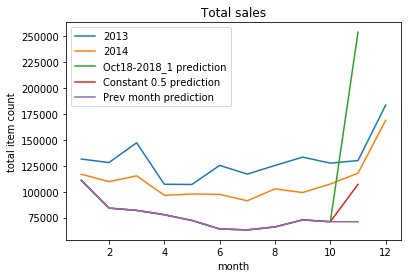

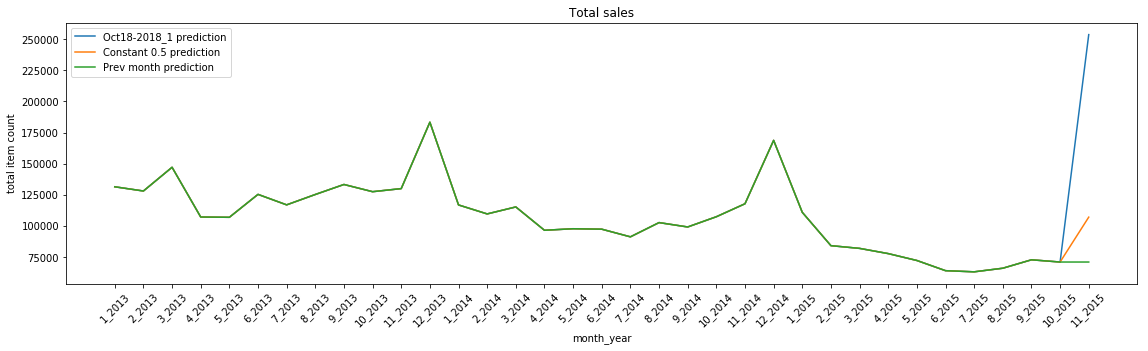

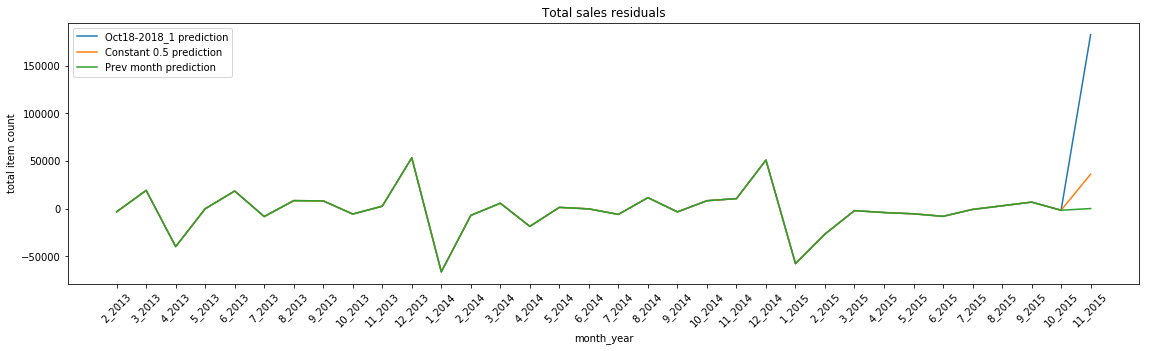

In [41]:
y_test = pd.DataFrame(pred_submit,columns=['item_cnt_month'])
#saveName='constant_0p38'
#saveplots=True

total_item_cnt_2013 = data['sales_2013'].groupby(['date_block_num','Y_M'])['item_cnt_day'].sum().values
total_item_cnt_2014 = data['sales_2014'].groupby(['date_block_num','Y_M'])['item_cnt_day'].sum().values
total_item_cnt_2015 = data['sales_2015'].groupby(['date_block_num','Y_M'])['item_cnt_day'].sum().values
yearlySales = [total_item_cnt_2013,total_item_cnt_2014,total_item_cnt_2015]

kwargs = {'yearlySales':yearlySales,
        'y_test':y_test,
        'saveName':saveName,
        'saveplots':saveplots,
        'saveFolder':saveFolder}

ut.plotYearly(**kwargs)
ut.plotYearly_v2(**kwargs)
ut.plotResidual(**kwargs)

# Prepare submission file

In [24]:
test_sorted = data['test'].sort_values(by=groupby_list).reset_index(drop=True)
submit = pd.concat([test_sorted,y_test],axis=1)
submit = submit.sort_values(by="ID").reset_index(drop=True)

# sanity check
print 'These numbers below should match:'
print 'y_test.iloc[0] =',y_test.iloc[0].values[0] 
print 'submit[submit["ID"]==22987] = ',submit[submit["ID"]==22987]["item_cnt_month"].values[0]

submit = submit[["item_cnt_month"]]
submit.index.name="ID"
submit.head()

submitName=''
if submitName=='': 
    submitName=saveName
if(createSubmit):submit.to_csv('submit_'+submitName+'.csv')

These numbers below should match:
y_test.iloc[0] = 1.5802608847337987
submit[submit["ID"]==22987] =  1.5802608847337987
